In [ ]:
import zipfile
import os

# Specify the uploaded zip file name (adjust according to the uploaded file)
zip_file_name = '/content/data.zip'  # Replace with the actual file name
extraction_path = '/content'  # Directory where you want to extract the files

# Ensure the extraction directory exists
os.makedirs(extraction_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)


In [ ]:
import os
import random
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import MeanIoU


In [ ]:
import os

# Paths to image and label directories
image_folder = '/content/data/images'
label_folder = '/content/data/labels'

# Get list of files in the directory
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.tif')])
label_files = sorted([f for f in os.listdir(label_folder) if f.endswith('.png')])

# Extract base filenames (without extensions) for comparison
image_basenames = {os.path.splitext(f)[0] for f in image_files}
label_basenames = {os.path.splitext(f)[0] for f in label_files}

# Find unmatched labels and remove them
unmatched_labels = label_basenames - image_basenames

for label_file in unmatched_labels:
    label_path = os.path.join(label_folder, f"{label_file}.png")
    try:
        os.remove(label_path)  # Permanently remove unmatched label
        print(f"Removed unmatched label: {label_path}")
    except FileNotFoundError:
        print(f"File not found: {label_path}")

print("Unmatched labels removed.")


Unmatched labels removed.


In [ ]:
# Resize image and label
def resize_image_and_label(image_path, label_path, target_size=(128, 128)):
    image = Image.open(image_path)
    label = Image.open(label_path)
    image = image.resize(target_size, Image.BILINEAR)
    label = label.resize(target_size, Image.NEAREST)
    return np.array(image), np.array(label)

# Normalize image
def normalize_image(image):
    image = image.astype(np.float32)
    image /= image.max()  # Normalize to [0, 1]
    return image

# One-hot encode labels for water mask in channel 11
def one_hot_encode_labels(label, num_classes):
    one_hot = np.zeros((*label.shape, num_classes), dtype=np.float32)
    # Assume channel 11 represents the water mask
    one_hot[..., 0] = (label == 11).astype(np.float32)
    return one_hot

# Data augmentation
def augment_data(image, label):
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True
    )
    image = np.expand_dims(image, 0)
    label = np.expand_dims(label, 0)
    for img_batch, lbl_batch in zip(datagen.flow(image), datagen.flow(label)):
        augmented_image = img_batch[0]
        augmented_label = lbl_batch[0]
        break
    return augmented_image, augmented_label


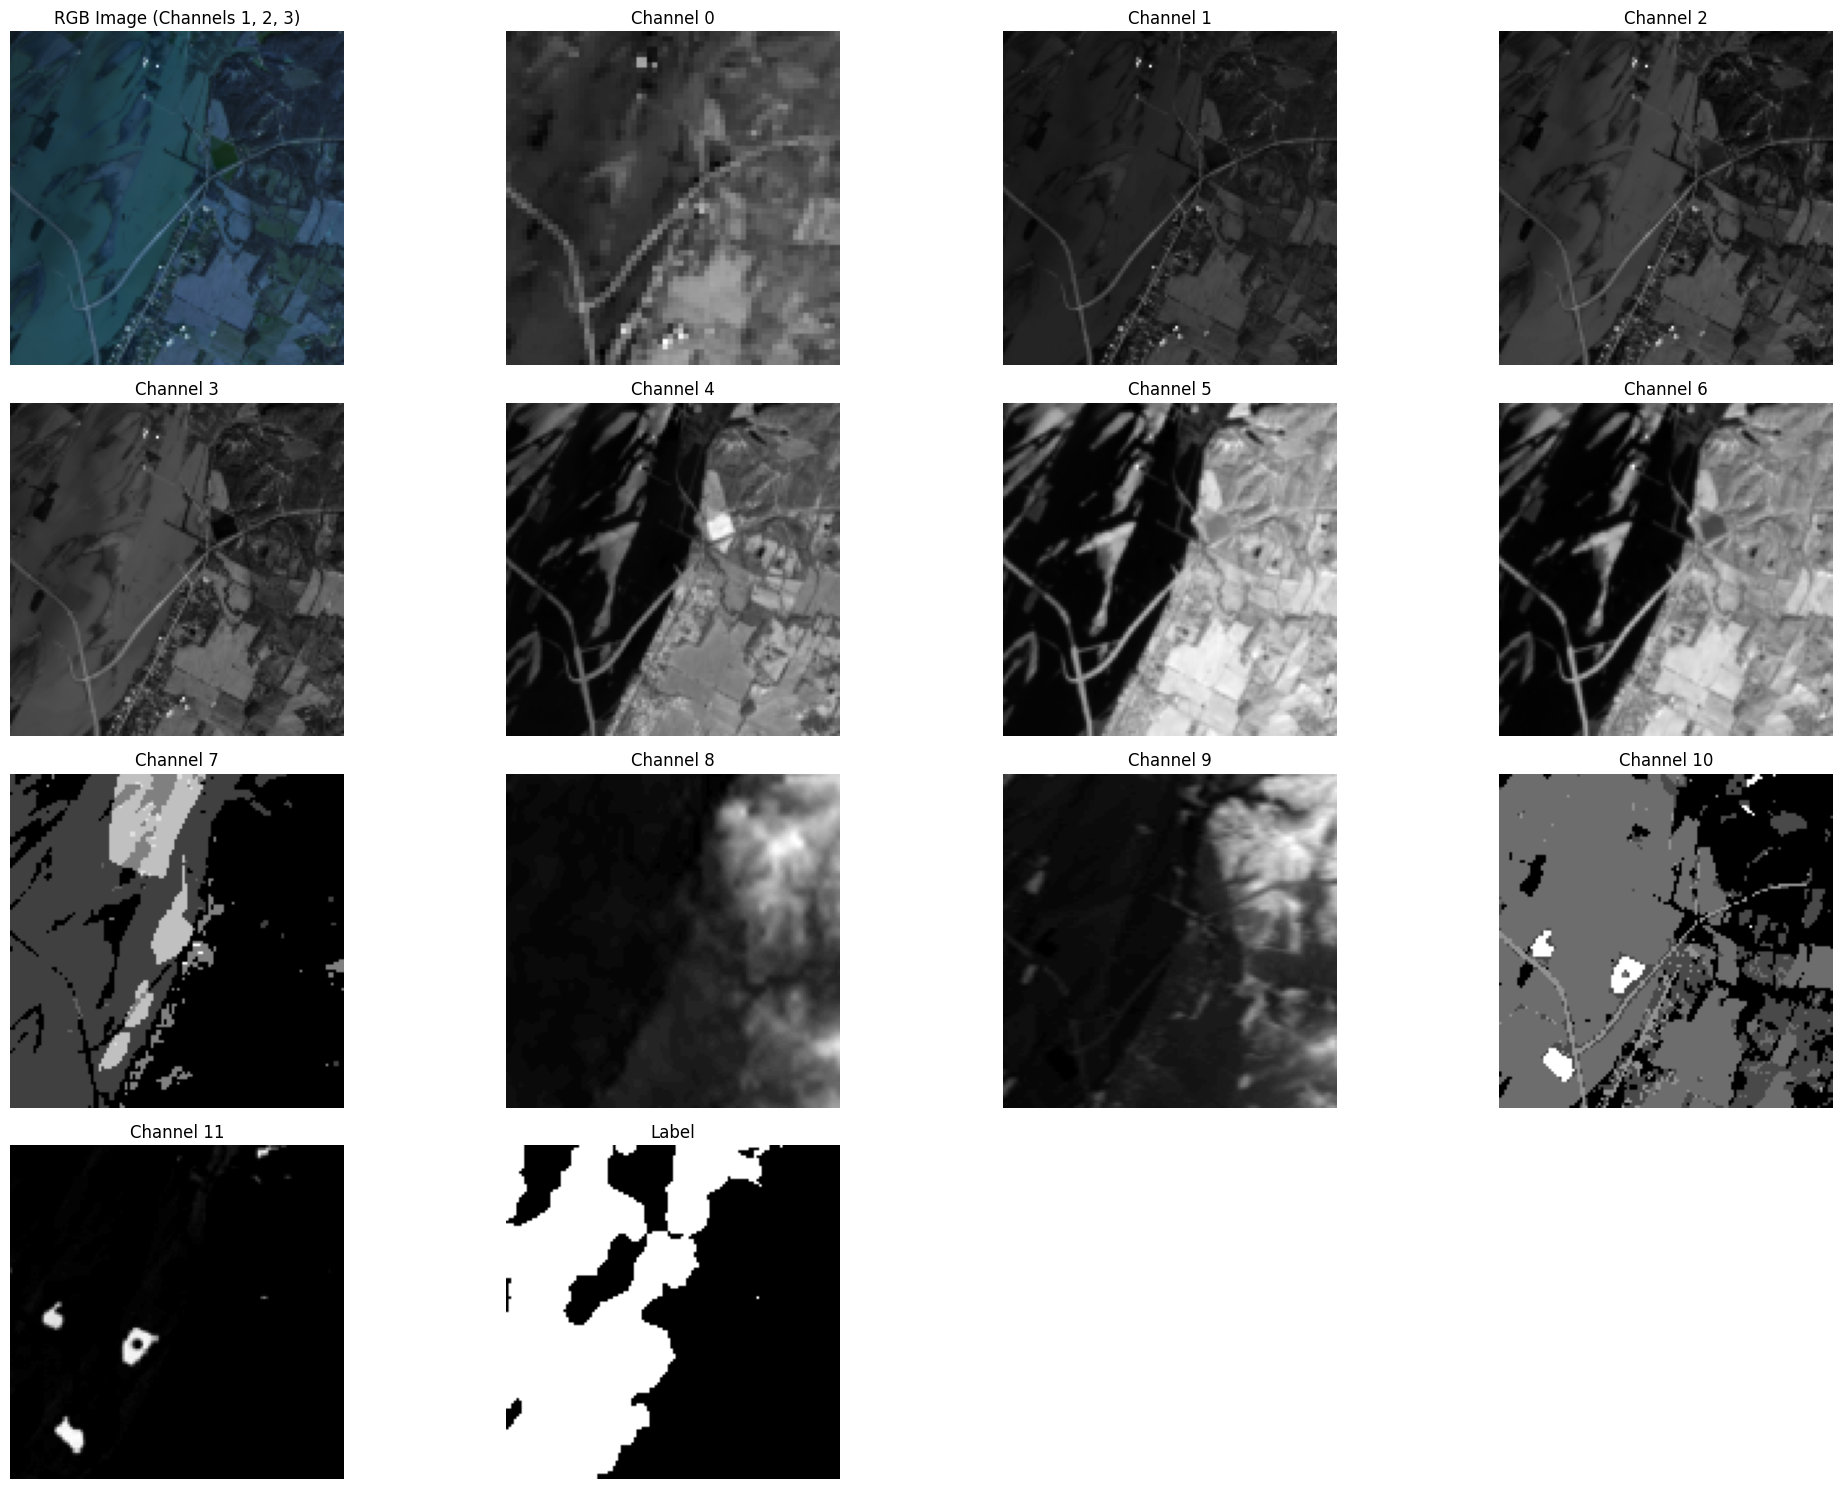

<ipython-input-17-c02afb85b6b1>:26: RuntimeWarning: invalid value encountered in divide
  image_channel = image_channel.astype(np.float32) / image_channel.max()


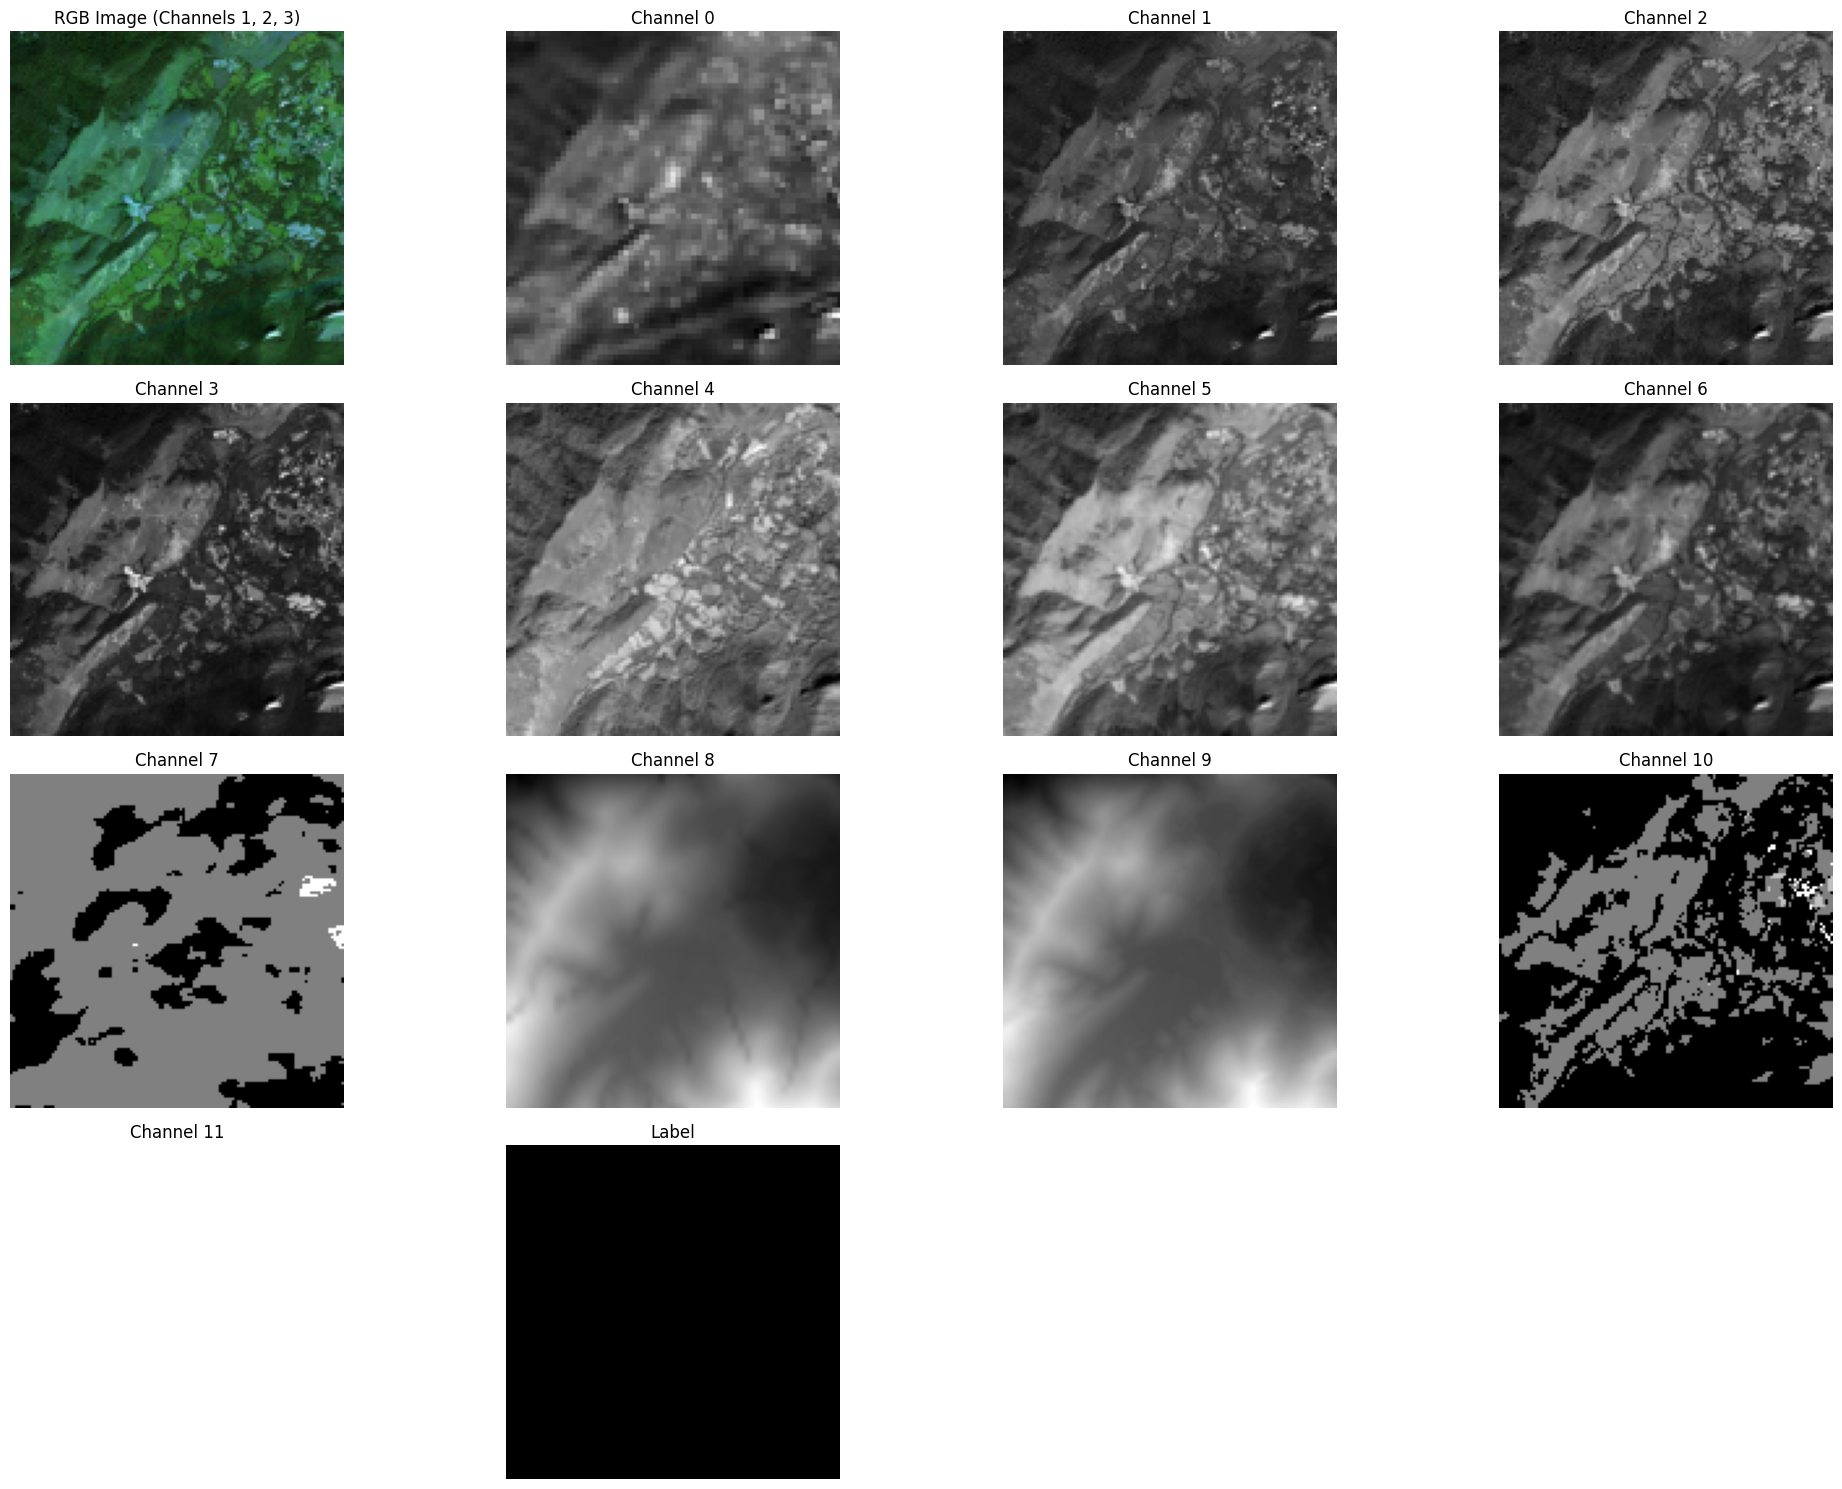

In [ ]:
# Randomly select 2 images
selected_indices = random.sample(range(len(image_files)), 2)

# Function to visualize each channel and RGB channels with the label
def visualize_image_and_label(image_path, label_path):
    # Load the image using tifffile
    image = tiff.imread(image_path)
    num_channels = image.shape[-1]  # Get the number of channels
    num_rows = 4
    num_cols = 4

    plt.figure(figsize=(20, 15))

    # Display the RGB image (assuming channels 1, 2, and 3 are RGB)
    if num_channels > 3:
        rgb_image = np.stack([image[..., 1], image[..., 2], image[..., 3]], axis=-1)
        rgb_image = rgb_image.astype(np.float32) / rgb_image.max()
        plt.subplot(num_rows, num_cols, 1)
        plt.imshow(rgb_image)
        plt.title('RGB Image (Channels 1, 2, 3)')
        plt.axis('off')

    # Display each channel individually
    for i in range(num_channels):
        image_channel = image[..., i]
        image_channel = image_channel.astype(np.float32) / image_channel.max()
        plt.subplot(num_rows, num_cols, i + 2)
        plt.imshow(image_channel, cmap='gray')
        plt.title(f'Channel {i}')
        plt.axis('off')

    # Load and display the label
    label = Image.open(label_path)
    label = np.array(label)
    plt.subplot(num_rows, num_cols, num_channels + 2)
    plt.imshow(label, cmap='gray')
    plt.title('Label')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize the randomly selected images
for idx in selected_indices:
    img_path = os.path.join(image_folder, image_files[idx])
    lbl_path = os.path.join(label_folder, label_files[idx])
    visualize_image_and_label(img_path, lbl_path)

In [ ]:
num_images = len(image_files)
num_labels = len(label_files)
num_images, num_labels

(306, 306)

In [ ]:
# Install TensorFlow addons for DeepLabV3
!pip install tensorflow-addons


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.5 MB/s eta 0:00:00


In [ ]:


# Model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 12)]    0         
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 3)       39        
                                                                 
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 256)         2359552   
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 128)         295040    
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 64)          73792     
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 64)         0   

In [ ]:
# Define callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)


In [ ]:
train_split = int(0.7 * len(image_files))
val_split = int(0.9 * len(image_files))

train_images = image_files[:train_split]
train_labels = label_files[:train_split]
val_images = image_files[train_split:val_split]
val_labels = label_files[train_split:val_split]
test_images = image_files[val_split:]
test_labels = label_files[val_split:]

train_dataset = create_dataset([os.path.join(image_folder, f) for f in train_images],
                               [os.path.join(label_folder, f) for f in train_labels])
val_dataset = create_dataset([os.path.join(image_folder, f) for f in val_images],
                             [os.path.join(label_folder, f) for f in val_labels])
test_dataset = create_dataset([os.path.join(image_folder, f) for f in test_images],
                              [os.path.join(label_folder, f) for f in test_labels])

In [ ]:
# Build and compile the model
input_tensor = tf.keras.layers.Input(shape=(128, 128, 12))

# Add a convolutional layer to reduce the number of channels from 12 to 3
x = tf.keras.layers.Conv2D(3, (1, 1), padding='same', activation='relu')(input_tensor)

# Load the DenseNet121 model with pretrained ImageNet weights (excluding the top classification layer)
base_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Pass the input through the base model
x = base_model(x)

# Add layers to ensure the output matches the input dimensions
x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)

# Adjust the number of upsampling layers to achieve the target output dimensions
x = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # (8, 8, 64)
x = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # (16, 16, 32)
x = tf.keras.layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # (32, 32, 16)
x = tf.keras.layers.Conv2DTranspose(8, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)   # (64, 64, 8)
x = tf.keras.layers.Conv2DTranspose(4, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)   # (128, 128, 4)

# Ensure output size is (128, 128) with 1 channel
x = tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid')(x)  # Output layer with 1 channel

# Create the full model
model = tf.keras.Model(inputs=input_tensor, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])

# Model summary
model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 12)]    0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 3)       39        
                                                                 
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 256)         2359552   
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         295040    
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 64)          73792     
 anspose)                                                     

In [ ]:
# Fit the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50


ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 12


UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
UnidentifiedImageError: cannot identify image file '/content/data/images/0.tif'
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "<ipython-input-25-20988ecaa5e1>", line 7, in generator
    img, lbl = resize_image_and_label(img_path, lbl_path, target_size)

  File "<ipython-input-16-9ed979765fab>", line 3, in resize_image_and_label
    image = Image.open(image_path)

  File "/usr/local/lib/python3.10/dist-packages/PIL/Image.py", line 3498, in open
    raise UnidentifiedImageError(msg)

PIL.UnidentifiedImageError: cannot identify image file '/content/data/images/0.tif'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_52873]